This notebook aims to produce a custom dataset to use for the prediction of secondary structure of MMACHC using a CNN. 

# FASTA files

In [1]:
import numpy as np
from Bio import SeqIO
from Bio.PDB import PDBParser, DSSP
import requests
import os
from Bio import SeqIO
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler, DataLoader
from sklearn.metrics import f1_score
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import sklearn as sl
import matplotlib.pyplot as plt
import difflib

In [2]:
def download_uniprot_fasta(uniprot_id, save_dir="."):
    
    # Make sure directory exists
    os.makedirs(save_dir, exist_ok=True)

    # UniProt REST API endpoint
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"

    # Request the FASTA file
    response = requests.get(url)
    if response.status_code == 200:
        fasta_data = response.text
        save_path = os.path.join(save_dir, f"{uniprot_id}.fasta")
        
        with open(save_path, "w") as f:
            f.write(fasta_data)
        
        print(f"✅ Saved {uniprot_id}.fasta to {save_path}")
        return save_path
    else:
        print(f"❌ Error {response.status_code}: Could not fetch FASTA for {uniprot_id}")
        return None



In [3]:
# IMPORTING FASTAS
# proteins with following codes are going to be imported
codes = [
    "Q9Y4U1", # MMACHC    # from the biogrid.org
    "P69905","Q92526","Q99707","P06129","P20061","F4JJE0",
    "P49368","P50991","P68036","Q13228","Q9H3L0","P0C671",
    "P48643","P40227","Q92526","Q99832","P50990","Q96N21",
    "Q13371","Q9H2J4","Q9H4M7","P04156","P17897","Q14258",
    # from MMADHC with biogrid.org
    "Q9NWT8","Q8NCR6","Q8N1D5","Q6P1W5","A6NI79","Q08830",
    "O75420","P31273","Q6S000","O75251","Q96S79","P23246",
    "Q13685","Q3ZCV2","Q9BW66","P0C7P0","Q02930","Q86XK2",
    "Q8TAE8","P17481","Q14244","Q96T17","Q9UL63","Q9BYN8",
    "Q96PU9","Q9UNK4","Q8TBY8","Q12837","P21912","Q9P0N9",
    "Q15363","Q3SY00","P41240",
    # from FAD (cofactor of MMACHC) with biogrid.org
    "Q8NFF5","Q9P2G3","Q8TD55","Q9P287","Q7Z5A8","Q9NQT6",
    "Q9BUE6","Q9NRG1","Q04864","P36406","Q5JTZ9","Q9H845",
    "Q53RE8","P20073","P27695","Q7Z2E3","Q13733","Q13825",
    "P56945","Q8TD16","P29311","Q14CZ0","Q07021","P0DPI2",
    "Q9P0P8","P0C671","Q4G0X9","P55774","O75794","P30307",
    # core B12 metabolism and transport (already listed)
    "Q9NRW7",  # MMADHC
    "P49419",  # CUBN
    "Q9UK51",  # AMN
    "P30556",  # LMBRD1
    "Q9BV10",  # TCN1
    "P20020",  # TCN2
    "Q9Y4P5",  # GIF (CBLIF)
    "Q9BXR5",  # MUT
    "P36055",  # MTR
    
    # related enzymes in folate/methionine metabolism linked to B12 function
    "P04818",  # MTHFR - Methylenetetrahydrofolate reductase
    "P41250",  # MTRR - Methionine synthase reductase (recycles MTR)
    "P33274",  # CBS - Cystathionine beta-synthase
    "P05091",  # SHMT1 - Serine hydroxymethyltransferase 1 (cytosolic)
    "P34896",  # SHMT2 - Serine hydroxymethyltransferase 2 (mitochondrial)
    
    # vitamin B12 related transporters and binding proteins
    "Q9H2M9",  # ABCD4 - Lysosomal transporter linked to cobalamin processing
    "Q9NYV4",  # CD320 - Transcobalamin receptor
    
    # chaperones and accessory proteins involved in B12 enzyme maturation
    "Q9BYN6",  # MMAA - Methylmalonic aciduria cblA type protein
    "Q9NSZ0",  # MMAB - Adenosyltransferase (B12 adenosylation)
    "Q969U7",  # CLYBL - Citrate lyase beta-like protein, linked to cobalamin metabolism
    
    # other enzymes that rely on B12 derivatives or linked metabolic pathways
    "P10915",  # SUCLA2 - Succinate-CoA ligase subunit beta (mitochondrial)
    "Q9NQC7",  # MUTYH - DNA repair enzyme, linked to oxidative stress pathways
    "P30307",  # ACSF3 - Acyl-CoA synthetase family member 3
    
    # additional binding or transport related proteins (less direct but associated)
    "Q8N6T3"]  # CBLIF-like proteins or unknown function related to B12




In [4]:
# looking for FASTA
codes = np.array(codes)
codes = np.unique(codes)
print(f"Searching for {len(codes)} unique protein codes \n")

os.makedirs("pdb", exist_ok=True)
for code in codes:
    download_uniprot_fasta(f"{code}", save_dir="fasta")

Searching for 108 unique protein codes 

✅ Saved A6NI79.fasta to fasta/A6NI79.fasta
✅ Saved F4JJE0.fasta to fasta/F4JJE0.fasta
✅ Saved O75251.fasta to fasta/O75251.fasta
✅ Saved O75420.fasta to fasta/O75420.fasta
✅ Saved O75794.fasta to fasta/O75794.fasta
✅ Saved P04156.fasta to fasta/P04156.fasta
✅ Saved P04818.fasta to fasta/P04818.fasta
✅ Saved P05091.fasta to fasta/P05091.fasta
✅ Saved P06129.fasta to fasta/P06129.fasta
✅ Saved P0C671.fasta to fasta/P0C671.fasta
✅ Saved P0C7P0.fasta to fasta/P0C7P0.fasta
✅ Saved P0DPI2.fasta to fasta/P0DPI2.fasta
✅ Saved P10915.fasta to fasta/P10915.fasta
✅ Saved P17481.fasta to fasta/P17481.fasta
✅ Saved P17897.fasta to fasta/P17897.fasta
✅ Saved P20020.fasta to fasta/P20020.fasta
✅ Saved P20061.fasta to fasta/P20061.fasta
✅ Saved P20073.fasta to fasta/P20073.fasta
✅ Saved P21912.fasta to fasta/P21912.fasta
✅ Saved P23246.fasta to fasta/P23246.fasta
✅ Saved P27695.fasta to fasta/P27695.fasta
✅ Saved P29311.fasta to fasta/P29311.fasta
✅ Saved P3030

# PDB files

In [5]:
def download_alphafold_pdb(uniprot_code, save_path):
    """Download AlphaFold PDB for given UniProt ID."""
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_code}-F1-model_v4.pdb"
    r = requests.get(url)
    if r.status_code == 200:
        with open(save_path, "wb") as f:
            f.write(r.content)
        return True
    else:
        print(f"❌ Could not download {uniprot_code} (status {r.status_code})")
        return False

def get_secondary_structure(pdb_file):
    """Run DSSP and return H/E/C list aligned to residues in the PDB."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("model", pdb_file)
    model = next(structure.get_models())
    dssp = DSSP(model, pdb_file)

    sec_list = []
    for key in dssp.keys():
        ss = dssp[key][2]  # DSSP secondary structure
        sec_list.append(ss if ss != ' ' else 'C')  # convert blanks to Coil
    return sec_list

for code in codes:
    # download PDB
    pdb_dir = 'pdb'
    fasta_dir = 'fasta'
    pdb_path = os.path.join(pdb_dir, f"{code}.pdb")
    if not os.path.exists(pdb_path):
        if not download_alphafold_pdb(code, pdb_path):
            continue  # skip if not found

    # load sequence from FASTA
    fasta_path = os.path.join(fasta_dir, f"{code}.fasta")
    seq_record = SeqIO.read(fasta_path, "fasta")
    seq = str(seq_record.seq)

    # get DSSP secondary structure
    try:
        ss_list = get_secondary_structure(pdb_path)
    except Exception as e:
        print(f"❌ DSSP failed for {code}: {e}")
        continue

    # align to sequence length (AlphaFold should match exactly)
    if len(ss_list) != len(seq):
        print(f"⚠ Length mismatch for {code}: seq={len(seq)}, ss={len(ss_list)}")

    print(f"{code} → {''.join(ss_list)}")


A6NI79 → -----------PPPP---PPPP--PPPPPPPPP-----TTSHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-SPPHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--S-------------------
F4JJE0 → -----------------SSPEEEEEEE--TT--HHHHHHHHHHHTSSSSEEEEEEE--HHHHHHHT---SS-HHHHHHHHHT-TT-SEEEES--SS--HHHHHHHT-SEEEEESS----TTSS-S-TTHHHHHTT-EEEE-PPTT--HHHHHHHHHHTHHHHHHHHHHTT--HHHHT--TTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTT--HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHSS---------------------------PPPPP---
O75251 → ---------------------------------------------------PPPPP-SHHHHHHHHHHHHHHHHHHHSB-EEEEE-STHHHHHHHHHSTTT-GGGGTB---S-GGG-SEEEEES--BTTTHHHHHHHHTTSPSSPEEEEESHHHHH-GGGTT-SSB-S-GGGTS--SEEE--SSPPHHHHHHHHHHHHHHHTT--HHHHHTT-
O75420 → --------STHHHHHHHS----SSPPPP-------PPTT---HHHHHHT--TTPPPPGGG-STTTTTT--SS-PPPGGGS---HHHHHHHHS-TTHHHHHHHHTT-PPPPPP---------------------S-------S------

# Produce protein data
We need to merge FASTA data with PDB data for all inputted proteins

In [6]:
# --- Constants ---
all_residues = ['A','C','E','D','G','F','I','H','K','M','L','N','Q','P','S','R','T','W','V','Y','X']
no_seq_idx = 21  # index for 'NoSeq'
sec_map = ['H', 'E', 'C']  # 3 class classification
max_len = 700

data = []

for code in codes:
    faa = f"fasta/{code}.fasta"
    pdb_file = f"pdb/{code}.pdb"

    # skip if either file does not exist
    if not os.path.isfile(faa) or not os.path.isfile(pdb_file):
        print(f"Skipping {code}: fasta or pdb file missing")
        continue

    try:
        # 1. load fasta
        record = SeqIO.read(faa, "fasta")
        seq = str(record.seq)
        L = len(seq)

        # 2. one hot encoding the primary sequence
        prot = np.zeros((max_len, len(all_residues)), dtype=float)
        for j, aa in enumerate(seq[:max_len]):  # truncate to 700
            idx = all_residues.index(aa) if aa in all_residues else no_seq_idx
            prot[j, idx] = 1

        # 3. load pdb
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure(code, pdb_file)
        model = next(structure.get_models())

        dssp = DSSP(model, pdb_file)  
        ss_list = []
        for key in dssp.keys():
            ss = dssp[key][2]  # DSSP secondary structure code
            ss_list.append(ss if ss != ' ' else 'C')  # convert blanks to coil

        # 4. one hot encoding the secondary structure
        sec = np.zeros((max_len, len(sec_map)), dtype=float)
        for j, ss in enumerate(ss_list[:max_len]):  # truncate to 700
            idx = sec_map.index(ss) if ss in sec_map else sec_map.index('C')
            sec[j, idx] = 1

        # 5. combine it all
        feat = np.concatenate([prot, sec], axis=1)  # shape: (700, 25)

        print(f"{code} → {feat.shape}")
        data.append(feat)
    except Exception as e:
        print(f"Skipping {code} due to error: {e}")


A6NI79 → (700, 24)
F4JJE0 → (700, 24)
O75251 → (700, 24)
O75420 → (700, 24)
O75794 → (700, 24)
P04156 → (700, 24)
P04818 → (700, 24)
P05091 → (700, 24)
P06129 → (700, 24)
P0C671 → (700, 24)
P0C7P0 → (700, 24)
P0DPI2 → (700, 24)
P10915 → (700, 24)
P17481 → (700, 24)
P17897 → (700, 24)
P20020 → (700, 24)
P20061 → (700, 24)
P20073 → (700, 24)
P21912 → (700, 24)
P23246 → (700, 24)
P27695 → (700, 24)
P29311 → (700, 24)
P30307 → (700, 24)
P30556 → (700, 24)
P31273 → (700, 24)
P33274 → (700, 24)
P34896 → (700, 24)
Skipping P36055: fasta or pdb file missing
P36406 → (700, 24)
P40227 → (700, 24)
P41240 → (700, 24)
P41250 → (700, 24)
P48643 → (700, 24)
P49368 → (700, 24)
P49419 → (700, 24)
P50990 → (700, 24)
P50991 → (700, 24)
P55774 → (700, 24)
P56945 → (700, 24)
P68036 → (700, 24)
P69905 → (700, 24)
Q02930 → (700, 24)
Q04864 → (700, 24)
Q07021 → (700, 24)
Q08830 → (700, 24)
Q12837 → (700, 24)
Q13228 → (700, 24)
Q13371 → (700, 24)
Q13685 → (700, 24)
Q13733 → (700, 24)
Q13825 → (700, 24)
Q14244 

# Preparing the datasets for the training
Here we prepare the datasets. All coded proteins will be divided in training (90%), validation (10%) and test set (just MMACHC)

In [7]:
# test set is only MMACHC, the rest will be divided in training and validation
test_set = data[0]
rest_set = data[1:]
print('Tot prot inputted:',len(rest_set))

Tot prot inputted: 104


In [8]:
# converting sets into pandas dataframes
rows = []

for i in range(len(rest_set)):
    prot = rest_set[i]
    for j in (range(np.shape(prot)[0])):
        row = prot[j,:] # taking all the features
        rows.append({
            'prot_id': i, 
            **{f'feat_{k}': row[k] for k in range(np.shape(prot)[1])}
        })

df = pd.DataFrame(rows)
# 24 standard features + the first one now indices the protein
# the index 22 is now what relates to no residue
print(np.shape(df))

rows = []
prot_id = -1

for j in (range(np.shape(test_set)[0])):
    row = prot[j,:] # taking all the features
    rows.append({
        'prot_id': prot_id, 
        **{f'feat_{k}': row[k] for k in range(np.shape(test_set)[1])}
    })

df_test = pd.DataFrame(rows)
print(np.shape(df_test))


(72800, 25)
(700, 25)


In [9]:
prot_test = np.array(df_test)
prot = np.array(df)

prot = prot[prot[:,1:].sum(axis = 1) == 2]
prot_test = prot_test[prot_test[:,1:].sum(axis = 1) == 2]
print(np.shape(prot))
print(np.shape(prot_test))


(45611, 25)
(282, 25)


In [10]:
X = prot[:,:21]
X_test = prot_test[:,:21]

# making up the classes
Y = np.argmax(prot[:,22:], axis = 1)
Y_test = np.argmax(prot_test[:,22:], axis = 1)

print('Classes in the dataset:',np.unique(Y))
print('Classes occurrences:',np.unique(Y, return_counts = True)[1])
print('Percentages (%) occurrences:',np.unique(Y, return_counts = True)[1]/sum(np.unique(Y, return_counts = True)[1])*100)



Classes in the dataset: [0 1 2]
Classes occurrences: [14698  5960 24953]
Percentages (%) occurrences: [32.22468264 13.06702331 54.70829405]


In [11]:
# extract indices for training proteins and validation proteins
# fraction of points in test size
frac = 0.1
prot_indices = np.arange(len(codes))
#prot_indices = prot_indices[:100] # selection of proteins
np.random.shuffle(prot_indices)
val_proteins = prot_indices[:int(frac * len(prot_indices))]
train_proteins = prot_indices[int(frac * len(prot_indices)):]

mask_train = np.isin(X[:,0], train_proteins)
mask_val = np.isin(X[:,0], val_proteins)
print(np.sum(mask_train))
print(np.sum(mask_val))

41323
4288


# Model setup and training
Here we setup the CNN and try to train 

In [12]:
# create sliding windows
def apply_sliding_window(X, Y, window_size):
    half_w = window_size // 2
    prot_ids = np.unique(X[:, 0])
    X_windows = []
    Y_labels = []

    for pid in prot_ids:
        prot_mask = X[:, 0] == pid
        prot_feats = X[prot_mask][:, 1:]  # remove prot_id
        prot_labels = Y[prot_mask]

        L = len(prot_feats)
        # pad with zeros on both sides
        pad = np.zeros((half_w, prot_feats.shape[1]))
        padded_feats = np.vstack([pad, prot_feats, pad])

        for i in range(L):
            window = padded_feats[i:i+window_size].flatten()
            label = prot_labels[i]
            X_windows.append(window)
            Y_labels.append(label)

    X_windows = np.array(X_windows)
    Y_labels = np.array(Y_labels)
    print("X_windows shape:", X_windows.shape)  # Should be (N, window_size * D)
    print("Y_labels shape:", Y_labels.shape)    # Should be (N,)
    return np.array(X_windows), np.array(Y_labels)


In [13]:
print(np.shape(X),np.shape(Y))
print(np.shape(X_test),np.shape(Y_test))

(45611, 21) (45611,)
(282, 21) (282,)


## Model definition

In [14]:
# Dataset maker (Sliding Window per protein approach)
class SlidingWindowProteinDataset(Dataset):
    def __init__(self, X, Y, window_size, is_test):
        if(is_test == False):
            self.samples = []
            self.labels = []
    
            half_w = window_size // 2
            prot_ids = np.unique(X[:, 0])
    
            for pid in prot_ids:
                prot_mask = X[:, 0] == pid
                prot_feats = X[prot_mask][:, 1:].astype(np.float32)  # exclude prot_id
                prot_labels = Y[prot_mask]
                L = len(prot_feats)
    
                # Pad
                pad = np.zeros((half_w, prot_feats.shape[1]), dtype=np.float32)
                padded_feats = np.vstack([pad, prot_feats, pad])
    
                for i in range(L):
                    window = padded_feats[i:i+window_size]
                    label = prot_labels[i]
                    self.samples.append(window)
                    self.labels.append(label)
                    
        if(is_test == True):
            self.samples = []
            self.labels = []
    
            half_w = window_size // 2
            prot_ids = np.unique(X[:, 0])
    
            for pid in prot_ids:
                prot_mask = X[:, 0] == pid
                prot_feats = X[prot_mask][:, 1:].astype(np.float32)  # exclude prot_id
                prot_labels = Y[prot_mask]
                L = len(prot_feats)
    
                # Pad
                pad = np.zeros((half_w, prot_feats.shape[1]), dtype=np.float32)
                padded_feats = np.vstack([pad, prot_feats, pad])
    
                for i in range(L):
                    window = padded_feats[i:i+window_size]
                    label = prot_labels[i]
                    self.samples.append(window)
                    self.labels.append(label)
        

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.tensor(self.samples[idx])  # shape: (window_size, feat_dim)
        x = x.permute(1, 0)  # shape: (feat_dim, window_size)
        y = torch.tensor(self.labels[idx], dtype = torch.long)
        return x, y

In [15]:
# Model (CNN)
class CNNClassifier(nn.Module):
    def __init__(self, in_channels, out_classes, conv_filters, hidden_sizes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=conv_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_filters, out_channels=conv_filters, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.3)
        layers = []
        input_dim = conv_filters
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            input_dim = h
        self.hidden_layers = nn.ModuleList(layers)        
        self.fc_out = nn.Linear(input_dim, out_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.mean(dim=2)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.fc_out(x)
        return x

Training the model with epochs 50, window sizes 7, hidden layers [16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

New best score: 0.603


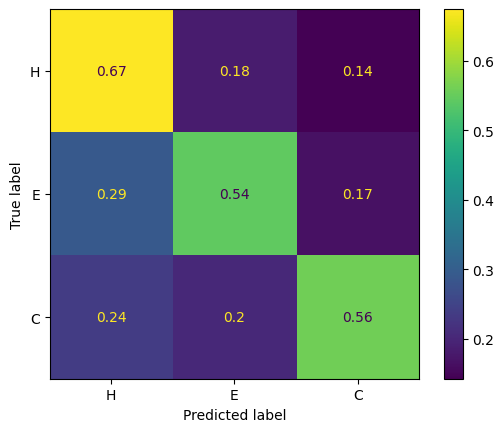

Training the model with epochs 50, window sizes 7, hidden layers [32, 16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

New best score: 0.61


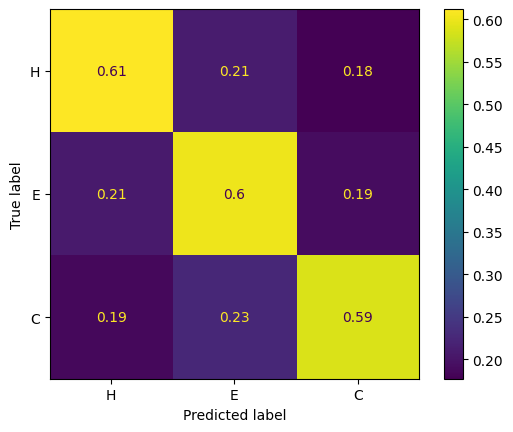

Training the model with epochs 50, window sizes 7, hidden layers [64, 16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

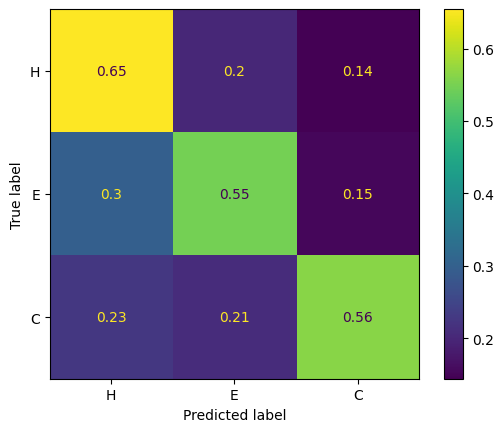

Training the model with epochs 50, window sizes 9, hidden layers [16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

New best score: 0.623


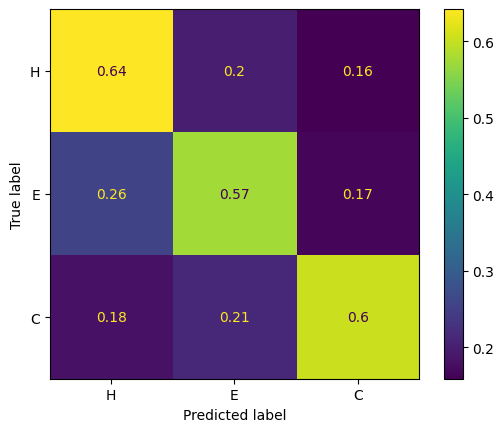

Training the model with epochs 50, window sizes 9, hidden layers [32, 16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

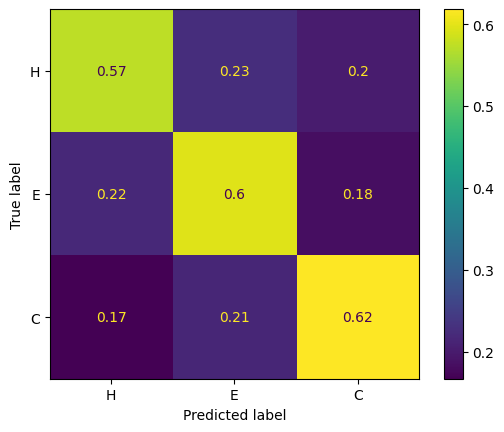

Training the model with epochs 50, window sizes 9, hidden layers [64, 16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

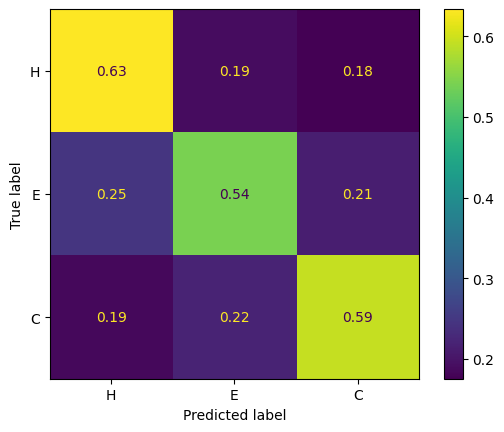

Training the model with epochs 50, window sizes 11, hidden layers [16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

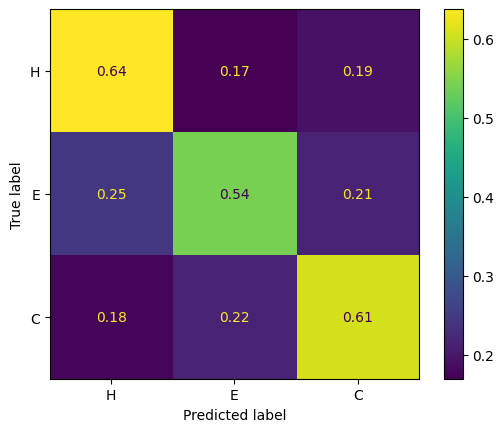

Training the model with epochs 50, window sizes 11, hidden layers [32, 16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

New best score: 0.634


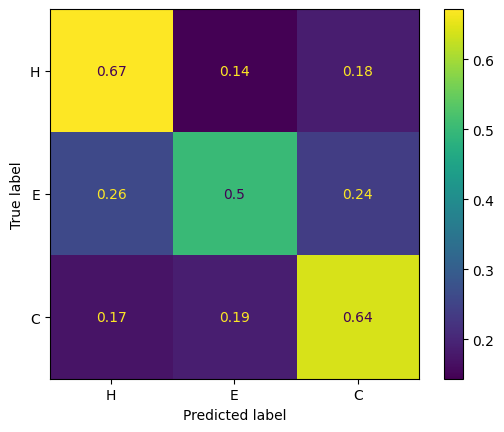

Training the model with epochs 50, window sizes 11, hidden layers [64, 16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

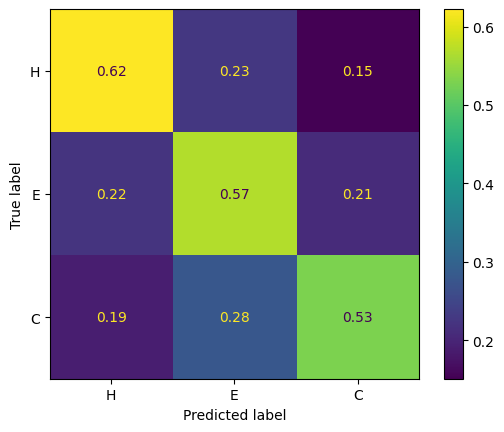

Training the model with epochs 50, window sizes 13, hidden layers [16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

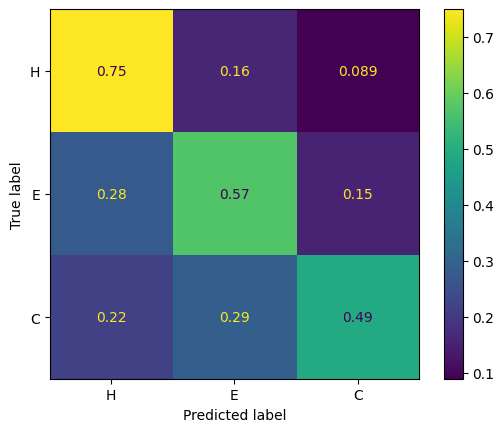

Training the model with epochs 50, window sizes 13, hidden layers [32, 16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

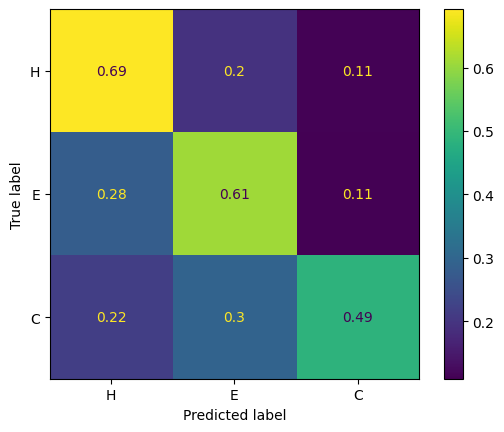

Training the model with epochs 50, window sizes 13, hidden layers [64, 16], learning rate 0.001


Epoch 1/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/323 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/323 [00:00<?, ?it/s]

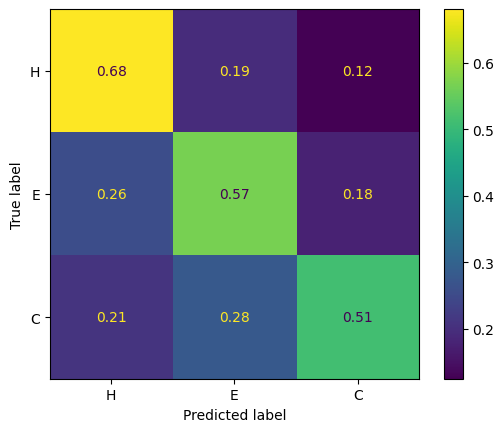

Best final score is 0.6338326111985053 with params {'ws': 11, 'hl': [32, 16], 'max_iters': 50, 'lr': 0.001}


In [16]:
# Grid search
window_sizes = [7, 9, 11, 13]
hl_sizes = [[16], [32, 16], [64, 16]]
max_iters = [50]
learning_rates = [1e-3]
best_score = -1
filters = 32

num_features = X.shape[1]-1
num_classes = len(np.unique(Y))  # or Y.max() + 1

for ws in window_sizes:
    for hl in hl_sizes:
        for epochs in max_iters:
            for lr in learning_rates:
                test_accuracies = []
                # dataset instances
                train_dataset = SlidingWindowProteinDataset(X[mask_train], Y[mask_train], window_size=ws, is_test = False)
                val_dataset = SlidingWindowProteinDataset(X[mask_val], Y[mask_val], window_size=ws, is_test = False)
                test_dataset = SlidingWindowProteinDataset(X_test, Y_test, window_size=ws, is_test = True)

                train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
                
                print(f"Training the model with epochs {epochs}, window sizes {ws}, hidden layers {hl}, learning rate {lr}")
                model = CNNClassifier(
                    in_channels=num_features,
                    out_classes=num_classes,
                    conv_filters=filters, 
                    hidden_sizes = hl
                )
                optimizer = optim.Adam(model.parameters(), lr=lr)
                # class balance
                # compute class frequencies
                class_counts = np.bincount(Y[mask_train])
                class_weights = 1.0 / (class_counts + 1e-6)  # avoid div by zero
                class_weights = class_weights / class_weights.sum()  # normalize
                
                # convert to tensor
                class_weights = torch.tensor(class_weights, dtype=torch.float32)
                
                # use class_weights in loss
                criterion = nn.CrossEntropyLoss(weight=class_weights)
                scores = []
                for epoch in range(epochs):
                    model.train()
                    running_loss = 0.0
                    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
                    for xb, yb in train_iterator:
                        optimizer.zero_grad()
                        preds = model(xb)
                        loss = criterion(preds, yb)
                        loss.backward()
                        optimizer.step()
                        
                        running_loss += loss.item()
                        train_iterator.set_postfix(loss=running_loss / (train_iterator.n + 1))
                        
                    all_preds, all_labels, all_probs = [],[],[]
                    with torch.no_grad():
                        for xb, yb in val_loader:
                            out = model(xb)
                            probs = torch.softmax(out, dim = 1)
                            all_preds.append(out.argmax(dim=1).cpu())
                            all_labels.append(yb.cpu())
                            all_probs.append(probs.cpu())
                        all_preds = torch.cat(all_preds).numpy()
                        all_labels = torch.cat(all_labels).numpy()
                        all_probs = torch.cat(all_probs).numpy()
                    score = f1_score(all_labels, all_preds, average='weighted')
                    scores.append(score)

                
                #plt.plot(np.arange(epochs),scores, label = 'Test accuracy')
                #plt.show()
                    
                if(score > best_score):
                    print(f'New best score: {round(score,3)}')
                    best_score = score
                    best_params = {
                        'ws':ws,
                        'hl':hl,
                        'max_iters':epochs,
                        'lr':lr
                    }
                    best_model = model
            classes = ['H','E','C']
            cm = sl.metrics.confusion_matrix(all_labels, all_preds)
            cm = cm / cm.sum(axis=1, keepdims=True)
                
                
            disp = sl.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                                        display_labels = classes
                                                        )
            disp.plot()
                
            plt.show()

print(f"Best final score is {best_score} with params {best_params}")



# Testing the model
In this cell we test the model on specifically MMACHC

In [17]:
# testing the best model against MMACHC sequence

num_features = X.shape[1]-1
num_classes = len(np.unique(Y))

all_preds, all_labels, all_probs = [],[],[]
with torch.no_grad():
    for xb, yb in test_loader:
        out = best_model(xb)
        probs = torch.softmax(out, dim = 1)
        all_preds.append(out.argmax(dim=1).cpu())
        all_labels.append(yb.cpu())
        all_probs.append(probs.cpu())
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
        

In [18]:
(all_probs.max(axis = 1))

array([0.9966348 , 0.97778404, 0.864277  , 0.5254161 , 0.67395854,
       0.8963573 , 0.9488347 , 0.85675776, 0.93245745, 0.9688128 ,
       0.97120184, 0.9551306 , 0.9613365 , 0.9443618 , 0.9011419 ,
       0.5229101 , 0.8561215 , 0.81109834, 0.794778  , 0.81412095,
       0.8036485 , 0.8025033 , 0.7373496 , 0.8210816 , 0.8016258 ,
       0.86394393, 0.903323  , 0.42965764, 0.88609535, 0.7631251 ,
       0.9089257 , 0.5342321 , 0.8636557 , 0.73169   , 0.58806497,
       0.82060826, 0.8828988 , 0.9887578 , 0.9929428 , 0.9927053 ,
       0.997979  , 0.9921731 , 0.9628633 , 0.9880606 , 0.9196156 ,
       0.799058  , 0.60307324, 0.91691935, 0.92413324, 0.8843434 ,
       0.85577124, 0.75961983, 0.629756  , 0.7252221 , 0.68208504,
       0.83480614, 0.46117017, 0.647382  , 0.8094527 , 0.5350212 ,
       0.7952318 , 0.7362112 , 0.8907868 , 0.80296135, 0.6891892 ,
       0.60534364, 0.54679906, 0.5478967 , 0.5887205 , 0.61741036,
       0.572988  , 0.58907384, 0.60379845, 0.6673746 , 0.67040

In [19]:
len(np.where(all_labels == all_preds)[0]) / len(all_labels)

0.776595744680851

# Plot predicted DSSP

In [29]:
def plot_secondary_structure_multirow(real, pred,num_file, n_rows=4):
    assert len(real) == len(pred), "Sequences must be the same length"
    length = len(real)
    colors = {0: 'blue', 1: 'orange', 2: 'green'}
    class_names = {0: 'H (Helix)', 1: 'E (Sheet)', 2: 'C (Coil)'}
    
    # Calculate length per row (ceil division)
    row_len = (length + n_rows - 1) // n_rows

    fig, axes = plt.subplots(n_rows, 1, figsize=(15, 3 * n_rows), sharex=False)

    if n_rows == 1:
        axes = [axes]
    
    for r in range(n_rows):
        ax = axes[r]
        start = r * row_len
        end = min(start + row_len, length)
        
        segment_real = real[start:end]
        segment_pred = pred[start:end]
        segment_len = end - start
        
        mismatch = (np.array(segment_real) != np.array(segment_pred))
        
        # Red background on mismatch
        for i in range(segment_len):
            if mismatch[i]:
                ax.axvspan(i, i + 1, color='red', alpha=0.3)
        
        # Real sequence bars (top)
        for i, val in enumerate(segment_real):
            ax.bar(i, 1, color=colors[val], edgecolor='black', align='edge')
        
        # Predicted sequence bars (bottom)
        for i, val in enumerate(segment_pred):
            ax.bar(i, 0.4, color=colors[val], edgecolor='black', align='edge', bottom=-0.5)
        
        ax.set_ylim(-1, 1.2)
        ax.set_xlim(0, segment_len)
        ax.set_yticks([0, -0.3])
        ax.set_yticklabels(['Real', 'Predicted'])
        ax.set_xticks(np.arange(0, segment_len, max(1, segment_len // 10)))
        ax.set_ylabel(f'Row {r+1}')
    
    axes[-1].set_xlabel('Residue position (per row)')
    fig.suptitle('Secondary Structure Prediction vs Real (4 rows)')
    
    # Create legend
    legend_patches = [plt.Line2D([0], [0], color=colors[k], lw=8, label=class_names[k]) for k in colors]
    legend_patches.append(plt.Rectangle((0,0),1,1, color='red', alpha=0.3, label='Mismatch'))
    axes[0].legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'pred_seq_{num_file}.jpg')
    plt.show()



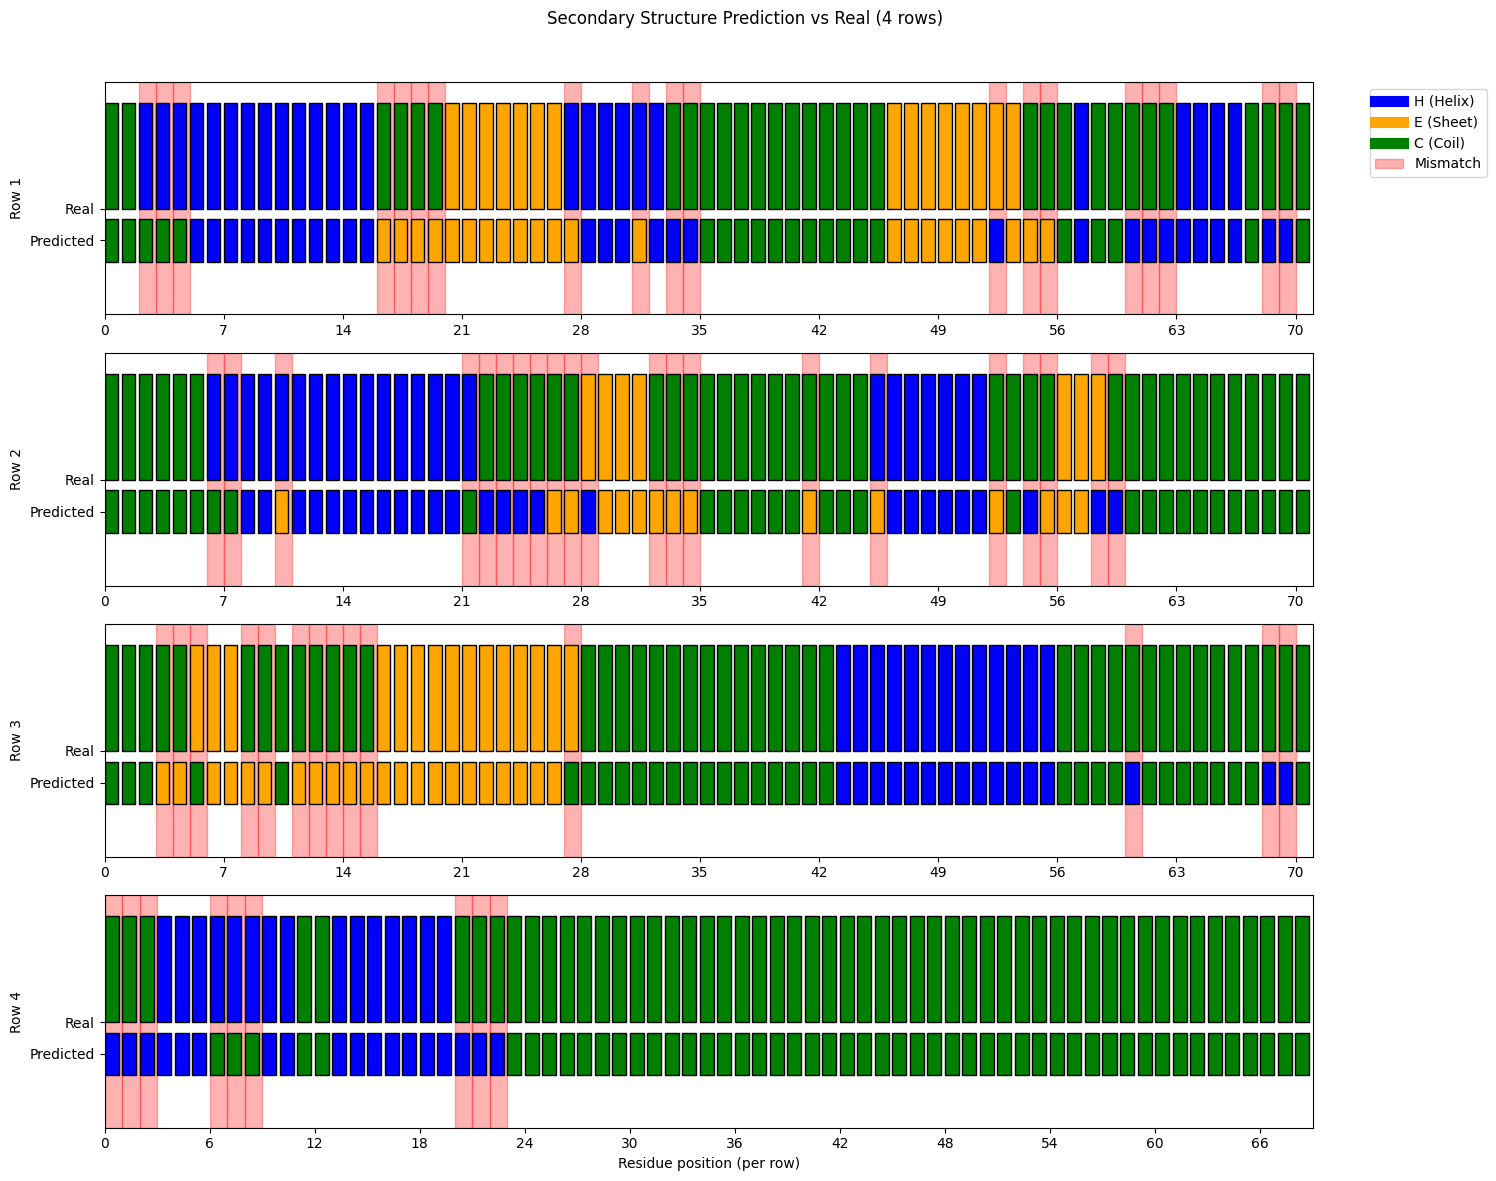

In [30]:
plot_secondary_structure_multirow(all_labels, all_preds, num_file = 'defXag')

## Confidence of predictions
Finally we plot the confidence of each prediction

In [23]:
def plot_confidence_multirow(real, prob, num_file, n_rows=4):
    """
    real: list/array of real class indices (0=H, 1=E, 2=C)
    prob: list/array of probabilities for predicted class (length matches real)
    num_file: output filename suffix
    n_rows: number of rows to split sequence
    """
    assert len(real) == len(prob), "Sequences must be the same length"
    length = len(real)
    
    colors_real = {0: 'blue', 1: 'orange', 2: 'green'}
    class_names = {0: 'H (Helix)', 1: 'E (Sheet)', 2: 'C (Coil)'}
    
    # Probability color thresholds
    def prob_to_color(p):
        if p < 0.5:
            return 'red'
        elif p < 0.75:
            return 'yellow'
        else:
            return 'green'
    
    row_len = (length + n_rows - 1) // n_rows
    fig, axes = plt.subplots(n_rows, 1, figsize=(15, 3 * n_rows), sharex=False)
    if n_rows == 1:
        axes = [axes]
    
    for r in range(n_rows):
        ax = axes[r]
        start = r * row_len
        end = min(start + row_len, length)
        
        segment_real = real[start:end]
        segment_prob = prob[start:end]
        segment_len = end - start
        
        # Real sequence (top)
        for i, val in enumerate(segment_real):
            ax.bar(i, 1, color=colors_real[val], edgecolor='black', align='edge')
        
        # Confidence bars (bottom) with probability-based colors
        for i, p in enumerate(segment_prob):
            ax.bar(i, 0.4, color=prob_to_color(p), alpha = 0.7, edgecolor='black', align='edge', bottom=-0.5)
        
        ax.set_ylim(-1, 1.2)
        ax.set_xlim(0, segment_len)
        ax.set_yticks([0, -0.3])
        ax.set_yticklabels(['Real', 'Confidence'])
        ax.set_xticks(np.arange(0, segment_len, max(1, segment_len // 10)))
        ax.set_ylabel(f'Row {r+1}')
    
    axes[-1].set_xlabel('Residue position (per row)')
    fig.suptitle('Secondary Structure: Real vs Prediction Confidence')
    
    # Legend
    legend_patches = [
        plt.Line2D([0], [0], color=colors_real[k], lw=8, label=class_names[k]) for k in colors_real
    ]
    legend_patches += [
        plt.Rectangle((0,0),1,1, color='red', label='p < 0.5', alpha = 0.8),
        plt.Rectangle((0,0),1,1, color='yellow', label='0.5 ≤ p < 0.75', alpha = 0.8),
        plt.Rectangle((0,0),1,1, color='green', label='p ≥ 0.75', alpha = 0.8)
    ]
    axes[0].legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'pred_conf_{num_file}.jpg')
    plt.show()


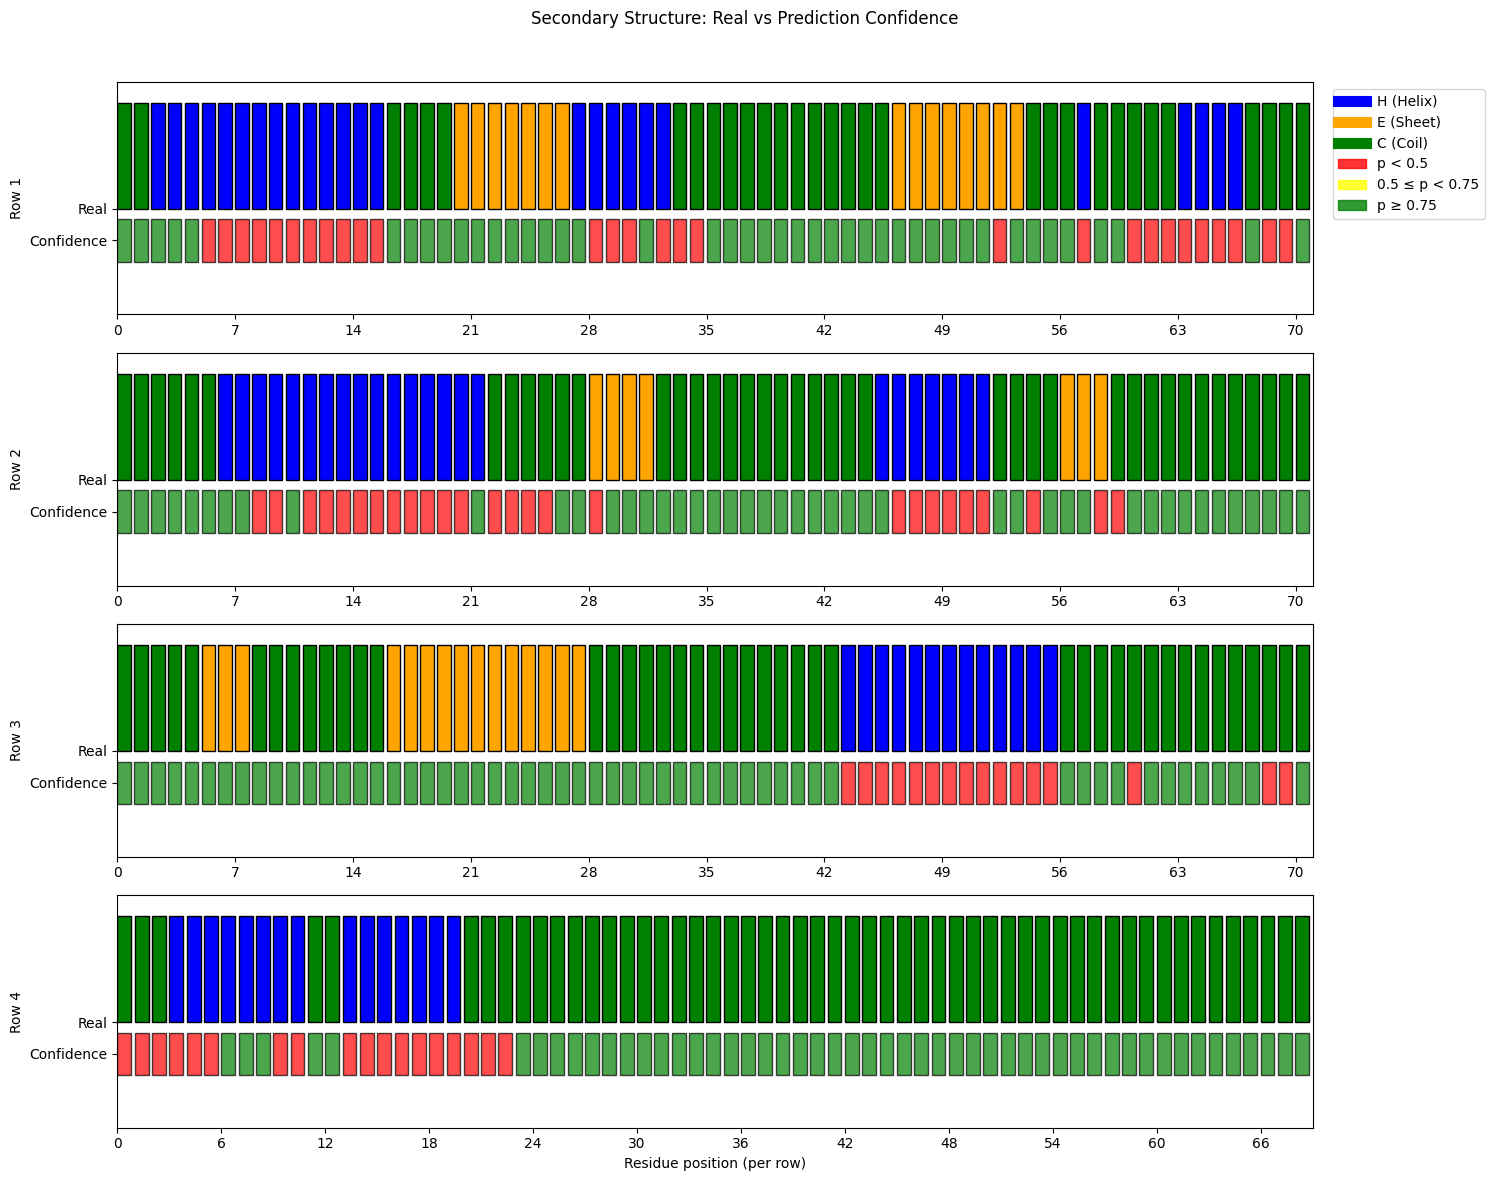

In [26]:
plot_confidence_multirow(all_labels, all_preds, num_file = 'defXag')